In [7]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz

import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse
import rtmtools.clirad.lw.info

import rtmtools.rrtmg.lw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse



importlib.reload(aerutils)
importlib.reload(aeranalyse)
importlib.reload(viz)

importlib.reload(cliradwrangle)
importlib.reload(cliradanalyse)
importlib.reload(rtmtools.clirad.lw.info)

importlib.reload(rrtmgwrangle)
importlib.reload(rrtmganalyse)

<module 'rtmtools.rrtmg.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/rrtmg/sw/analyse.py'>

In [8]:
name_molecule = r'$H_{2}O + CO_2 + O_{3}$'

#### Load CRD results

In [19]:
# Get lbl line-by-line results
pathout_crd = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H2008_H2O_O3_cut25/OUTPUT_RADSUM'
pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, cooling_rate = True, signed_fluxes = True)


In [13]:
# H1996 cutoff = 10 cm-1
pathout_crd1 = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H1996_CO2_cut10/OUTPUT_RADSUM'
pnl_crd1 = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd1, cooling_rate = True, signed_fluxes = True)


#### Load CLIRAD results

In [9]:
# Read OUTPUT_CLIRAD.dat
pathout_clirad = '/nuwa_cluster/home/jackyu/radiation/clirad/LW/examples/mls75_H2O_CO2_O3_H2012/OUTPUT_CLIRAD.dat'
pnl_clirad = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad, cooling_rate = True, signed_fluxes= True)


In [11]:
pathout_clirad_96 = '/nuwa_cluster/home/jackyu/radiation/clirad/LW/examples/mls75_H2O_O3/OUTPUT_CLIRAD.dat'
pnl_clirad_96 = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad_96, cooling_rate = True, signed_fluxes= True)

In [15]:
# prepare results Hitran 2012 updated version
def path_cliradlw_h2012():
    return '../clirad/LW/examples/mls75_CO2_H2012/CLIRAD_IR_output.dat'


def get_rateT(df, ratename = 'cooling rates'):
    return pd.DataFrame({'pressure': .5 * (df['p'].values[1:] + df['p'].values[: -1]),
                    ratename: df[ratename].values[1:]})


df = cliradwrangle.output_txtfile_to_DataFrame(path_cliradlw_h2012())

rateT_clirad2012 = get_rateT(df, ratename = 'cooling rates')

#### Load LBLRTM results

In [5]:
# Get AER line-by-line results
pathout_lblrtm = '/nuwa_cluster/home/jackyu/line_by_line/aerlbl_v12.2_package/runs/LW/run_mls70pro_H2O_O3/OUTPUT_RADSUM'
pnl_lblrtm = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_lblrtm, signed_fluxes = True, cooling_rate = True)



#### Load RRTMG results

In [10]:
pathout_rrtmg = '/nuwa_cluster/home/jackyu/radiation/rrtmg/LW/examples/mls70_H2O_CO2_O3/OUTPUT_RRTM'
pnl_rrtmg = rrtmgwrangle.OUTPUT_RRTM_to_pandasPanel(readfrom = pathout_rrtmg, signed_fluxes = True, cooling_rate = True)



# Total cooling rates

In [11]:
xlim_linear = (- 0.5, 3)

In [12]:
def plot_total_cooling_rates(infos_wavenumber = None, infos_spectralband = None):
    global molecule_name, xlim_linear
    
    levels_atm = [70, 30, 0]
    
    names, colours, linestyles, dfs = [], [], [], []
    
    if infos_wavenumber:
        names_wavenumber, colours_wavenumber, linestyles_wavenumber, pnls_wavenumber = \
        map(list, zip(*infos_wavenumber))
        dfs_wavenumber = [aeranalyse.sum_OUTPUT_RADSUM_over_wbands(pnl, V1 = 0, V2 = 3000) \
                          for pnl in pnls_wavenumber]        
        
        names.extend(names_wavenumber)
        colours.extend(colours_wavenumber)
        linestyles.extend(linestyles_wavenumber)
        dfs.extend(dfs_wavenumber)
        
        
    if infos_spectralband:
        names_spectralband, colours_spectralband, linestyles_spectralband, pnls_spectralband = \
        map(list, zip(*infos_spectralband))
        dfs_spectralband = [cliradanalyse.sum_OUTPUT_CLIRAD_over_wbands(pnl, wbands = range(1, 11))\
                            for pnl in pnls_spectralband]
        
        names.extend(names_spectralband)
        colours.extend(colours_spectralband)
        linestyles.extend(linestyles_spectralband)
        dfs.extend(dfs_spectralband)
        
    
    if infos_wavenumber or infos_spectralband:
        dfs_atm = [df.loc[levels_atm, :] for df in dfs]
        viz.tabulate_difference(dfs = dfs_atm, 
                                names = names,
                                title = 'Total cooling rate. {}'.format(name_molecule))         
 
        max_cr = max([df['cooling_rate'].max() for df in dfs])

        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Total cooling rate. {}'.format(name_molecule),
                              cooling_rate = True,
                             xlim_linear = xlim_linear, 
                              xlim_log = (- .1, 20) if max_cr >= 20 else None)
    
        display.display(plt.gcf()); plt.close()
    


Total cooling rate. $H_{2}O + CO_2 + O_{3}$

RRTMG
      pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -293.4640     0.0000 -293.4640       0.00000
30   299.70000 -311.4119    54.0219 -257.3900       2.11845
0   1013.00000 -423.5981   307.6566 -115.9415       1.37746

CLIRAD
       pressure     flux_up   flux_down    net_flux  cooling_rate
70     0.002417 -295.108436    0.013619 -295.094817     25.588815
30   299.800000 -312.492346   54.137694 -258.354652      2.270001
0   1013.000000 -423.786188  307.063026 -116.723162      1.552459

RRTMG - CLIRAD
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  1.644436  -0.013619  1.630817    -25.588815
30 -0.100000  1.080446  -0.115794  0.964652     -0.151551
0   0.000000  0.188088   0.593574  0.781662     -0.174999



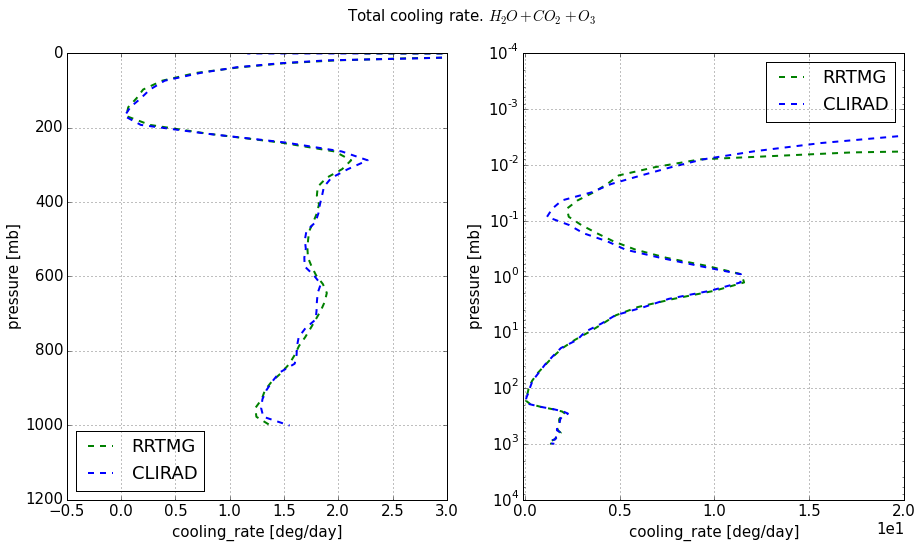

In [13]:
plot_total_cooling_rates(infos_wavenumber = [('RRTMG', 'g', '--', pnl_rrtmg)],\
                        infos_spectralband = [('CLIRAD', 'b', '--', pnl_clirad)])

In [24]:
xlim_linear = (-.5, 2)

In [14]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')